<a href="https://colab.research.google.com/github/duttagoutam/LJMUMasters/blob/master/ImageCaptioningFlickr8kFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
import keras
import string
import sys, time, os, warnings 
import numpy as np
import pandas as pd
import pydotplus
from pandas import DataFrame
from array import array
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Embedding
from keras.layers.merge import concatenate
from keras.layers.merge import add
from keras.layers.pooling import GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from numpy import argmax
from pickle import dump
from pickle import load
from keras.utils.vis_utils import model_to_dot


Using TensorFlow backend.


In [0]:
folderName='/content/drive/My Drive/App/storage/Flickr8k_Dataset'
imageDir=folderName+'/Images'

# Prepare Text Data

In [0]:
# Not To Run Always
# load the document into memory
def load_doc(fileName):
    # open the file as read only mode
    file = open(fileName, 'r')
    # read all the text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# Not To Run Always
# extract the predefined descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process the lines
    for line in doc.split('\n'):
        # split the line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # extract the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # remove the filename from image id
        image_id = image_id.split('.')[0]
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store the description in dictionary
        mapping[image_id].append(image_desc)
    return mapping

In [0]:
# Not To Run Always
# Clean the description
def clean_descriptions(descriptions):
    mapping = {}
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize the sentence
            desc = desc.split()
            # convert all word to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)
            # print(desc_list[i])
        mapping[key]= desc_list
        #print(mapping)
    return mapping

In [8]:
# Not To Run Always
#filename = folderName+'/results.csv'
folderName='/content/drive/My Drive/App/storage/Flickr8k_Dataset'
imageDir=folderName+'/Images'
filename = folderName+'/Flickr_TextData/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
#print("The number of unique file names : {}".format(len(doc)))
# parse descriptions
descriptions = load_descriptions(doc)
print('descriptions: %d ' % len(descriptions))
#print('descriptions:',descriptions)
# clean descriptions
cleandescriptions = clean_descriptions(descriptions)
print('clean_descriptions: %d ' % len(cleandescriptions))
#print('cleandescriptions: ', cleandescriptions)

descriptions: 8091 
clean_descriptions: 8091 


In [0]:
# Not To Run Always
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [0]:
# Not To Run Always
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [0]:
# Not To Run Always
#filename = folderName+'/results.csv'
folderName='/content/drive/My Drive/App/storage/Flickr8k_Dataset'
imageDir=folderName+'/Images'
filename = folderName+'/Flickr_TextData/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
#print("The number of unique file names : {}".format(len(doc)))
# parse descriptions
descriptions = load_descriptions(doc)
print('descriptions: %d ' % len(descriptions))
#print('descriptions:',descriptions)
# clean descriptions
cleandescriptions = clean_descriptions(descriptions)
print('clean_descriptions: %d ' % len(cleandescriptions))
#print('cleandescriptions: ', cleandescriptions)
# summarize vocabulary
vocabulary = to_vocabulary(cleandescriptions)
print('Vocabulary Size: %d' % len(vocabulary))
#print('Vocabulary:',vocabulary)
# save to file
save_descriptions(cleandescriptions, folderName+'/clean8kdescriptions.txt')
#all_tokens = ' '.join(descriptions.values()).split()
#vocabulary = set(all_tokens)
#print('Vocabulary Size: %d' % len(vocabulary))
#print('Vocabulary:',vocabulary)

descriptions: 8091 
clean_descriptions: 8091 
Vocabulary Size: 8763


In [11]:
count = 0
for key, desc_list in cleandescriptions.items():

  if count< 5:
    for desc in desc_list:
            print(key + ' ' + desc)
    count = count+1  

1000268201_693b08cb0e child in pink dress is climbing up set of stairs in an entry way
1000268201_693b08cb0e girl going into wooden building
1000268201_693b08cb0e little girl climbing into wooden playhouse
1000268201_693b08cb0e little girl climbing the stairs to her playhouse
1000268201_693b08cb0e little girl in pink dress going into wooden cabin
1001773457_577c3a7d70 black dog and spotted dog are fighting
1001773457_577c3a7d70 black dog and tricolored dog playing with each other on the road
1001773457_577c3a7d70 black dog and white dog with brown spots are staring at each other in the street
1001773457_577c3a7d70 two dogs of different breeds looking at each other on the road
1001773457_577c3a7d70 two dogs on pavement moving toward each other
1002674143_1b742ab4b8 little girl covered in paint sits in front of painted rainbow with her hands in bowl
1002674143_1b742ab4b8 little girl is sitting in front of large painted rainbow
1002674143_1b742ab4b8 small girl in the grass plays with fing

# Extract Features

In [0]:
# Not To Run Always
# extract the features from each photo from the directory
def extract_features(directory, maxFileCount):
	# first load the model
	in_layer = Input(shape=(224, 224, 3))
	model = VGG16(include_top=False, input_tensor=in_layer)
	print(model.summary())
	# extract the features from each photo
	features = dict()
	for name in listdir(directory):
		if maxFileCount == 0:
			break
		# load an image from file traversing through directory
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		# convert the image pixels to a numpy array
		image = img_to_array(image)
		# reshape the data for the model
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		# prepare the image for the VGG model
		image = preprocess_input(image)
		# get the features from the model
		feature = model.predict(image, verbose=0)
		# get image id from the filename
		image_id = name.split('.')[0]
		# store feature in dictionary
		features[image_id] = feature
		print('>%s' % name)
		maxFileCount = maxFileCount -1
	return features

In [0]:
# Not To Run Always
# extract features from all images
#directory = 'Flickr8k_Dataset'
path, dirs, files = next(os.walk(imageDir))
file_count = len(files)
print("file_count:", file_count)

maxFileCount = file_count

if file_count < maxFileCount :
  maxFileCount = file_count

directory = imageDir

features = extract_features(directory, maxFileCount)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open(folderName+'/features8k.pkl', 'wb'))
print('Image Features: %d' % len(features))

file_count: 8101
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 

# Loading Data

In [0]:
# load the doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [0]:
# load the pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

In [0]:
# split a dataset into train/test elements
def train_test_split(dataset):
	# order keys so the split is consistent
	ordered = sorted(dataset)
	# return split dataset as two new sets
	return set(ordered[:100]), set(ordered[100:200])

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        #print("tokens:",tokens)        
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        #print("image_id:", image_id)
        #print("image_desc:", image_desc)        
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [0]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset if k in all_features}
	#print(features)
	return features

In [0]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = list(descriptions.values())
	#print(lines)
	#lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	#print(tokenizer)
	return tokenizer

In [0]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [0]:
# calculate the length of the description with the most words
def maximum_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [21]:
# Not to run always
# prepare test set
# load test set

filename = folderName+'/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
print('Descriptions: test=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features(folderName+'/features8k.pkl', train)
print('Photos: test=%d' % len(train_features))
#print('test_features:', test_features)
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
#print(tokenizer)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: test=6000
Photos: test=6000
Vocabulary Size: 29769
Description Length: 34


# Define Model

In [0]:

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, desc, image, max_length):
	Ximages, XSeq, y = list(), list(),list()
	vocab_size = len(tokenizer.word_index) + 1
	# integer encode the description
	seq = tokenizer.texts_to_sequences([desc])[0]
	# split one sequence into multiple X,y pairs
	for i in range(1, len(seq)):
		# select
		in_seq, out_seq = seq[:i], seq[i]
		# pad input sequence
		in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
		# encode output sequence
		out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
		# store
		Ximages.append(image)
		XSeq.append(in_seq)
		y.append(out_seq)
	# Ximages, XSeq, y = array(Ximages), array(XSeq), array(y)
	return [Ximages, XSeq, y]

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length, n_step):
	# loop until we finish training
	while 1:
		# loop over photo identifiers in the dataset
		keys = list(descriptions.keys())
		for i in range(0, len(keys), n_step):
			Ximages, XSeq, y = list(), list(),list()
			for j in range(i, min(len(keys), i+n_step)):
				image_id = keys[j]
				# retrieve photo feature input
				image = features[image_id][0]
				# retrieve text input
				desc = descriptions[image_id]
				# generate input-output pairs
				in_img, in_seq, out_word = create_sequences(tokenizer, desc, image, max_length)
				for k in range(len(in_img)):
					Ximages.append(in_img[k])
					XSeq.append(in_seq[k])
					y.append(out_word[k])
			# yield this batch of samples to the model
			yield [[np.array(Ximages), np.array(XSeq)], np.array(y)]

In [24]:
# Not to run always
# prepare test set
# load test set

filename = folderName+'/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
print('Descriptions: test=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features(folderName+'/features8k.pkl', train)
print('Photos: test=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
#print(tokenizer)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)
n_photos_per_update =2
# test the data generator
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update)
inputs, outputs = next(generator)
print(inputs[0].shape)
print(inputs[1].shape)
print(outputs.shape)

Dataset: 6000
Descriptions: test=6000
Photos: test=6000
Description Length: 34
(8, 7, 7, 512)
(8, 34)
(8, 29769)


In [0]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor (encoder)
	inputs1 = Input(shape=(7, 7, 512))
	fe1 = GlobalMaxPooling2D()(inputs1)
	fe2 = Dense(128, activation='relu')(fe1)
	fe3 = RepeatVector(max_length)(fe2)
	# embedding
	inputs2 = Input(shape=(max_length,))
	emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
	emb3 = LSTM(256, return_sequences=True)(emb2)
	emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
	# merge inputs
	merged = concatenate([fe3, emb4])
	# language model (decoder)
	lm2 = LSTM(500)(merged)
	lm3 = Dense(500, activation='relu')(lm2)
	outputs = Dense(vocab_size, activation='softmax')(lm3)
	# tie encoder decoder together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	print(model.summary())
	plot_model(model, show_shapes=True, to_file=folderName+'/'+'plot.png')
	return model

# Evaluate Model

In [0]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [0]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

In [0]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		#actual.append([desc.split()])
		references = [d.split() for d in desc]
		actual.append(references)
		predicted.append(yhat.split())
	print('Actual:    %s' % desc)
	print('Predicted: %s' % yhat)
	# calculate BLEU score
	bleu = corpus_bleu(actual, predicted)
	return bleu

In [0]:
# Not to run always
# prepare test set
 
# load test set
filename = folderName+'/Flickr_TextData/Flickr_8k.trainImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features(folderName+'/features8k.pkl', test)
print('Photos: test=%d' % len(test_features))
# prepare tokenizer
tokenizer = create_tokenizer(test_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(test_descriptions)
print('Description Length: %d' % max_length)
# load the model
#filename = folderName+'/'+'model-ep001-loss4.523-val_loss4.065.h5'
filename = folderName+'/model_0.h5'
model = load_model(filename)
max_length =31
# evaluate model
bleu_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
print("bleu_score:",bleu_score)

Dataset: 6000
Descriptions: test=6000
Photos: test=6000
Vocabulary Size: 29769
Description Length: 34
bleu_score: 0.00029264491125986346


# Fit Model

In [30]:
# load dev set
filename = folderName+'/Flickr_TextData/Flickr_8k.testImages.txt'
#filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
dataset = load_set(filename)
print('Dataset: %d' % len(dataset))
# train-test split
train, test = train_test_split(dataset)
#print('train:',train)
#print('test:',test)
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
test_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', test)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions), len(test_descriptions)))
#print('train_descriptions:',train_descriptions)
#print('test_descriptions:',test_descriptions)
# photo features
train_features = load_photo_features(folderName+'/features8k.pkl', train)
test_features = load_photo_features(folderName+'/features8k.pkl', test)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
#max_length = max(len(s.split()) for s in list(train_descriptions.values()))
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 1000
Descriptions: train=100, test=100
Photos: train=100, test=100
Vocabulary Size: 501
Description Length: 27


In [31]:
print(test)
print(train)

{'2256133102_e2c8314ecb', '219301555_17883a51bd', '2089426086_7acc98a3a8', '2216695423_1362cb25f3', '2112921744_92bf706805', '2100816230_ff866fb352', '2207244634_1db1a1890b', '2120411340_104eb610b1', '2218609886_892dcd6915', '1998457059_c9ac9a1e1a', '2229179070_dc8ea8582e', '2170222061_e8bce4a32d', '1917265421_aeccf1ca38', '223299142_521aedf9e7', '2086513494_dbbcb583e7', '2162564553_96de62c7e6', '2251747182_6b67a3ab8b', '2225231022_1632d0a5aa', '2208310655_a3d83080c5', '2120383553_5825333a3f', '2041867793_552819a40b', '2078311270_f01c9eaf4c', '2309860995_c2e2a0feeb', '197107117_4b438b1872', '2140182410_8e2a06fbda', '2247889670_413db8094b', '2265096094_8cc34d669c', '2239938351_43c73c887c', '2077079696_03380d218b', '2271755053_e1b1ec8442', '2295750198_6d152d7ceb', '2064790732_219e52e19c', '2101457132_69c950bc45', '2228022180_9597b2a458', '211295363_49010ca38d', '191003285_edd8d0cf58', '2103568100_5d018c495b', '2194494220_bb2178832c', '2102360862_264452db8e', '2248487950_c62d0c81a9', '207

In [32]:
# Must Run before creating the model
# load training dataset (6K)
filename = folderName+'/Flickr_TextData/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features(folderName+'/features8k.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 29769
Description Length: 34


In [0]:
# define experiment
model_name = 'baseline1'
verbose = 2
n_epochs = 10
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 1
 
# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
	# define the model
	model = define_model(vocab_size, max_length)
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update)
	# fit model
	model.fit_generator(generator, steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
	# save model
	#filepath = folderName+'/'+'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
	#model.save(folderName+'/'+'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}-' + str(i) + '.h5') 
	model.save(folderName+'/'+'model_' + str(i) + '.h5')  
	# evaluate model on training data
	train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
	test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
	# store
	train_results.append(train_score)
	test_results.append(test_score)
	print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
# save results to file
resultFolder = folderName+'/Result'
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(resultFolder+'/'+model_name+'.csv', index=False)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 50)       1488450     input_2[0][0]              

In [34]:
resultFolder = folderName+'/Result'
resultFile = resultFolder+'/'+'baseline1.csv'
data = pd.read_csv(resultFile) 
# Preview the first 5 lines of the loaded data 
data.head(5)

,train,test
0,0.001097,0.00138


# Generate New Captions

In [36]:
# Must Run before creating the model
# load training dataset (6K)
filename = folderName+'/Flickr_TextData/Flickr_8k.testImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open(folderName+'/tokenizer8k.pkl', 'wb'))
#dump(tokenizer, open(folderName+'/tokenizer8k.txt', 'wb'))
#max_length = maximum_length(train_descriptions)
#print('Description Length: %d' % max_length)

Dataset: 1000
Descriptions: train=1000


In [0]:
# extract features from each photo in the directory
def extract_features(filename):
	# load the model
	in_layer = Input(shape=(224, 224, 3))
	model = VGG16(include_top=False, input_tensor=in_layer)
	print(model.summary())
	# re-structure the model
	#model.layers.pop()
	#model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	# load the photo
	image = load_img(filename, target_size=(224, 224))
	# convert the image pixels to a numpy array
	image = img_to_array(image)
	# reshape data for the model
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	# prepare the image for the VGG model
	image = preprocess_input(image)
	# get features
	feature = model.predict(image, verbose=0)
	return feature

In [0]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	# 'startseq two dogs playing in the snow endseq'
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		in_text = 'startseq'
		#in_text =''
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# print("sequence:", sequence)
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# print("pad sequence:", sequence)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [46]:
# load the tokenizer
tokenizer = load(open(folderName+'/tokenizer8k.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 34
print('Description Length: %d' % max_length)
# load the model
filename = folderName+'/model_0.h5'
model = load_model(filename)
# load and prepare the photograph
imageFileName = imageDir+'/'+'1446053356_a924b4893f.jpg'
photo = extract_features(imageFileName)

caption = generate_desc(model, tokenizer, photo, max_length) 
print(caption)

Description Length: 34
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56

In [0]:
# Display a list of images in a single figure with matplotlib.
def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [0]:
# load a pre-defined list of photo identifiers
def load_list(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        #identifier = line.split(' ')[0]
        dataset.append(line)
    return dataset

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

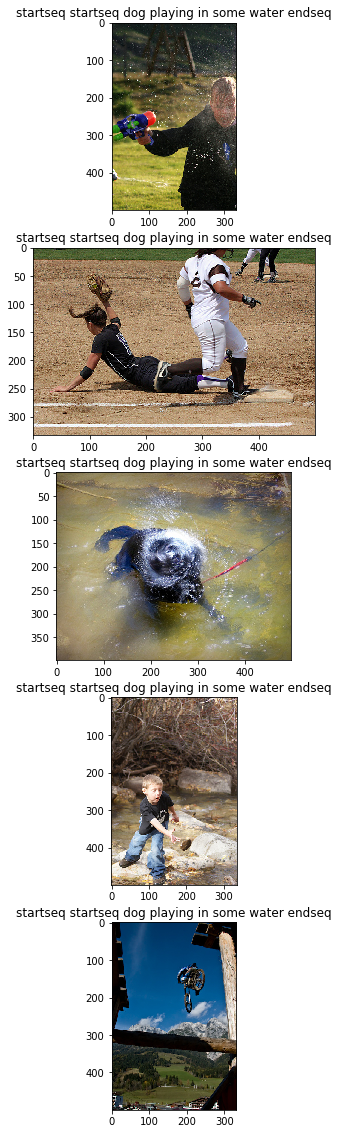

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

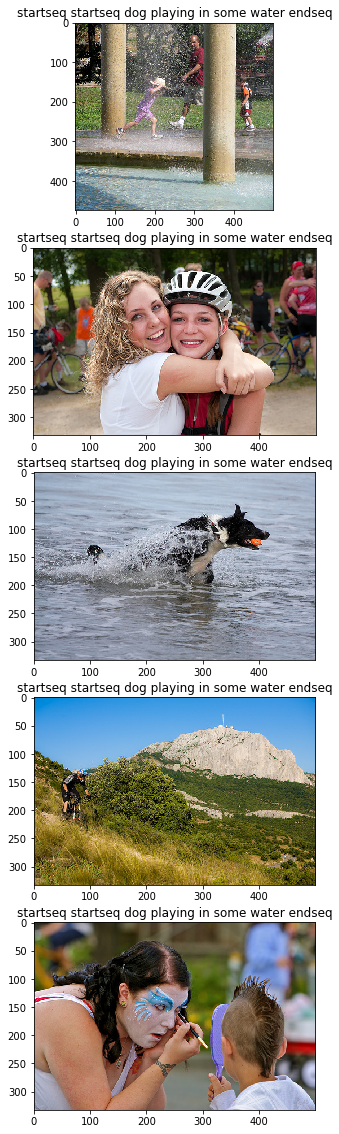

In [47]:
folderName='/content/drive/My Drive/App/storage/Flickr8k_Dataset'
imageDir=folderName+'/Images'
filename = folderName+'/Flickr_TextData/Flickr_8k.devImages.txt'
testImage = load_list(filename)
max_length = 34
# load the model
filename = folderName+'/model_0.h5'
model = load_model(filename)
list_img = []
list_desc = []
for i in range(10,20):
    image = load_img(imageDir +'/'+ testImage[i])
    list_img.append(np.asarray(image))
    # generate description
    photo = extract_features(imageDir +'/'+ testImage[i])
    description = generate_desc(model, tokenizer, photo, max_length)
    list_desc.append(description)
    if(len(list_img) == 5):
        show_images(images=list_img, cols=len(list_img), titles=list_desc)
        list_img = []
        list_desc = []

In [0]:
max_length = 21
print('Description Length: %d' % max_length)
# load the model
filename = folderName+'/model_0.h5'
print("filename:",filename)
model = load_model(filename)
# load and prepare the photograph
folderName='/content/drive/My Drive/App/storage/TomAndJerry'
imageDir=folderName+'/Images'
imageFileName = imageDir+'/'+'image0.jpg'
print("imageFileName:", imageFileName)
photo = extract_features(imageFileName)

caption = generate_desc(model, tokenizer, photo, max_length) 
print(caption)

Description Length: 21
filename: /content/drive/My Drive/App/storage/TomAndJerry/model_0.h5
imageFileName: /content/drive/My Drive/App/storage/TomAndJerry/Images/image0.jpg
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D

# Different Models

In [0]:
# Not run Always
# load training dataset (6K)
filename = folderName+'/Flickr_TextData/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
train_features = load_photo_features(folderName+'/features8k.pkl', test)
print('Photos: test=%d' % len(train_features))

# photo features
#train_features = load_photo_features(folderName+'/features8k.pkl', test)
#test_features = load_photo_features(folderName+'/features8k.pkl', test)
#print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))

# prepare tokenizer
tokenizer = create_tokenizer(test_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

#filename = folderName+'/Flickr_TextData/Flickr_8k.testImages.txt'
#train = load_set(filename)
#print('Dataset: %d' % len(train))
# descriptions
#train_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
#print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
#tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
#dump(tokenizer, open(folderName+'/tokenizer8k.pkl', 'wb'))
#dump(tokenizer, open(folderName+'/tokenizer8k.txt', 'wb'))
#max_length = maximum_length(train_descriptions)
#print('Description Length: %d' % max_length)

In [49]:
# load dev set
filename = folderName+'/Flickr_TextData/Flickr_8k.testImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# train-test split
#train, test = train_test_split(dataset)
#print('Train=%d, Test=%d' % (len(train), len(test)))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
test_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions), len(test_descriptions)))
# photo features
train_features = load_photo_features(folderName+'/features8k.pkl', train)
imageFileName = imageDir+'/'+'311146855_0b65fdb169.jpg'
test_features = extract_features(imageFileName)
#test_features = load_photo_features(folderName+'/features8k.pkl', test)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 1000
Descriptions: train=1000, test=1000
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool

In [0]:
# load the tokenizer
#tokenizer = load(open(folderName+'/tokenizer8k.pkl', 'rb'))
# pre-define the max sequence length (from training)
#max_length = 27
#print('Description Length: %d' % max_length)
# load the model
#filename = folderName+'/model_1.h5'
#model = load_model(filename)
# load and prepare the photograph
#imageFileName = imageDir+'/'+'311146855_0b65fdb169.jpg'
#test_features = extract_features(imageFileName)


model_name = 'findImage'
verbose = 1
n_epochs = 10
n_photos_per_update = 2
n_batches_per_epoch = 10 # int(len(train) / n_photos_per_update)
n_repeats = 1

train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # fit model
    #data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update
    model.fit_generator(data_generator(test_descriptions, train_features, tokenizer, max_length, vocab_size), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
    # evaluate model on training data
    #train_score = evaluate_model_new(model, test_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    #print("train_score:", train_score)
    print("test_score:", test_score)
    # store
    train_results.append(train_score)
    test_results.append(test_score)


  # save results to file
resultFolder = folderName+'/'+'Result'
df = DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(resultFolder+'/'+model_name+'.csv', index=False)
#caption = generate_desc(model, tokenizer, photo, max_length) 
#bleu_score =  evaluate_model_new(model, test_descriptions, photo, tokenizer, max_length)

#print("bleu_score:", bleu_score)
#for i in range(len(actualcaption)):
#  print("actualcaption:", actualcaption[i])
#  print("predictedcaption:", predictedcaption[i])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 30)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           input_24[0][0]                   
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 50)       249600      input_25[0][0]                   
____________________________________________________________________________________________

# Fit Dev Images

In [0]:
# split a dataset into train/test elements
def train_test_split(dataset):
	# order keys so the split is consistent
	ordered = sorted(dataset)
	# return split dataset as two new sets
	return set(ordered[:100]), set(ordered[100:200])

In [0]:
# load dev set
filename = folderName+'/Flickr_TextData/Flickr_8k.devImages.txt'
dataset = load_set(filename)
print('Dataset: %d' % len(dataset))
# train-test split
train, test = train_test_split(dataset)
print('Train=%d, Test=%d' % (len(train), len(test)))
# descriptions
train_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', train)
test_descriptions = load_clean_descriptions(folderName+'/clean8kdescriptions.txt', test)
print('Descriptions: train=%d, test=%d' % (len(train_descriptions), len(test_descriptions)))
# photo features
train_features = load_photo_features(folderName+'/features8k.pkl', train)
test_features = load_photo_features(folderName+'/features8k.pkl', test)
print('Photos: train=%d, test=%d' % (len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = maximum_length(train_descriptions)
print('Description Length: %d' % max_length)

Dataset: 1000
Train=100, Test=100
Descriptions: train=100, test=100
Photos: train=100, test=100
Vocabulary Size: 501
Description Length: 31


In [0]:
# evaluate the skill of the model
def evaluate_model_new(model, descriptions, photos, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc in descriptions.items():
		# generate description
		yhat = generate_desc(model, tokenizer, photos[key], max_length)
		# store actual and predicted
		actual.append([d.split() for d in desc])
		predicted.append(yhat.split())
	print('Actual:    %s' % desc)
	print('Predicted: %s' % yhat)
	# calculate BLEU score
	bleu = corpus_bleu(actual, predicted)
	return bleu

In [0]:
# define experiment
def run_experiment(model_name, func_name, verbose, n_epochs, n_photos_per_update, n_batches_per_epoch, n_repeats):
  # run experiment
  train_results, test_results = list(), list()
  for i in range(n_repeats):
    # define the model
    model = func_name(vocab_size, max_length)
    # fit model
    #data_generator(train_descriptions, train_features, tokenizer, max_length, n_photos_per_update
    model.fit_generator(data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size), steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model_new(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model_new(model, test_descriptions, test_features, tokenizer, max_length)
    print("train_score:", train_score)
    print("test_score:", test_score)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    #print('>%d: train=%f test=%f' % ((i+1), train_score, test_score))
  # save results to file
  resultFolder = folderName+'/Result'
  df = DataFrame()
  df['train'] = train_results
  df['test'] = test_results
  print(df.describe())
  df.to_csv(resultFolder+'/'+model_name+'.csv', index=False)

In [0]:
# define experiment
model_name = 'newbaseline1'
verbose = 1
n_epochs = 10
n_photos_per_update = 2
n_batches_per_epoch = 10 # int(len(train) / n_photos_per_update)
n_repeats = 1
#func = define_model(vocab_size, max_length)
run_experiment(model_name, define_model, verbose, n_epochs, n_photos_per_update, n_batches_per_epoch, n_repeats)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 31)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_7 (GlobalM (None, 512)          0           input_17[0][0]                   
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 31, 50)       25050       input_18[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
resultFile = resultFolder+'/'+'newbaseline1.csv'
data = pd.read_csv(resultFile) 
# Preview the first 5 lines of the loaded data 
data.head(5)

,train,test
0,0.000889,0.004006


In [0]:
# Generate Baseline model
model_name = 'baseline_generate'
n_repeats = 1
run_experiment(model_name, define_model, verbose, n_epochs, n_photos_per_update, n_batches_per_epoch, n_repeats)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 31)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_8 (GlobalM (None, 512)          0           input_19[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 31, 50)       25050       input_20[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
resultFile = resultFolder+'/'+'baseline_generate.csv'
data = pd.read_csv(resultFile) 
# Preview the first 5 lines of the loaded data 
data.head(5)

,train,test
0,0.001048,0.004351


In [0]:
# define the captioning model
def size_sm_fixed_vec(vocab_size, max_length):
	# feature extractor (encoder)
	inputs1 = Input(shape=(7, 7, 512))
	fe1 = GlobalMaxPooling2D()(inputs1)
	fe2 = Dense(64, activation='relu')(fe1)
	fe3 = RepeatVector(max_length)(fe2)
	# embedding
	inputs2 = Input(shape=(max_length,))
	emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
	emb3 = LSTM(256, return_sequences=True)(emb2)
	emb4 = TimeDistributed(Dense(64, activation='relu'))(emb3)
	# merge inputs
	merged = concatenate([fe3, emb4])
	# language model (decoder)
	lm2 = LSTM(500)(merged)
	lm3 = Dense(500, activation='relu')(lm2)
  
	outputs = Dense(vocab_size, activation='softmax')(lm3)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [0]:
# Generate Baseline model
model_name = 'size_sm_fixed_vec'
verbose = 1
n_epochs = 10
n_photos_per_update = 2
n_batches_per_epoch = 10 # int(len(train) / n_photos_per_update)
n_repeats = 1
run_experiment(model_name, size_sm_fixed_vec, verbose, n_epochs, n_photos_per_update, n_batches_per_epoch, n_repeats)

Epoch 1/10
10/10 [==============================] - 39s 4s/step - loss: 5.1322 - acc: 0.1775
Epoch 2/10
10/10 [==============================] - 31s 3s/step - loss: 2.3089 - acc: 0.2980
Epoch 3/10
10/10 [==============================] - 31s 3s/step - loss: 1.2320 - acc: 0.6240
Epoch 4/10
10/10 [==============================] - 31s 3s/step - loss: 0.9509 - acc: 0.8007
Epoch 5/10
10/10 [==============================] - 31s 3s/step - loss: 0.7135 - acc: 0.9000
Epoch 6/10
10/10 [==============================] - 31s 3s/step - loss: 0.5011 - acc: 0.9695
Epoch 7/10
10/10 [==============================] - 31s 3s/step - loss: 0.2668 - acc: 1.0000
Epoch 8/10
10/10 [==============================] - 31s 3s/step - loss: 0.1085 - acc: 1.0000
Epoch 9/10
10/10 [==============================] - 31s 3s/step - loss: 0.0463 - acc: 1.0000
Epoch 10/10
10/10 [==============================] - 31s 3s/step - loss: 0.0241 - acc: 1.0000
Actual:    ['startseq baby holds game control above its head and laug

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [0]:
resultFile = resultFolder+'/'+'size_sm_fixed_vec.csv'
data = pd.read_csv(resultFile) 
# Preview the first 5 lines of the loaded data 
data.head(5)

,train,test
0,0.00098,0.004217


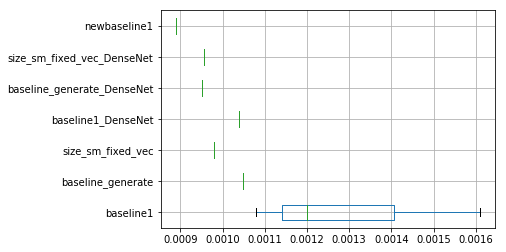

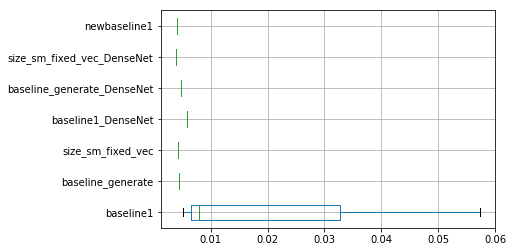

In [0]:
from pandas import read_csv
from matplotlib import pyplot
 
# load all .csv results into a dataframe
train, test = DataFrame(), DataFrame()
#directory = 'results'
directory =  folderName+'/Result'
for name in listdir(directory):
	if not name.endswith('csv'):
		continue
	filename = directory + '/' + name
	data = read_csv(filename, header=0)
	experiment = name.split('.')[0]
	train[experiment] = data['train']
	test[experiment] = data['test']
 
# plot results on train
train.boxplot(vert=False)
pyplot.show()
# plot results on test
test.boxplot(vert=False)
pyplot.show()